In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
index["market_cap"] = index["market_cap"].astype(float)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code").sort_values("market_cap",ascending=False)

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["ema_volume_corr"],group_percentages=[0.5])

In [8]:
analysises = []
for rolling_window in [20]:
    market.connect()
    prices = []
    for ticker in tqdm(index["ticker"]): 
        try:
            price = market.query("prices", {"ticker": ticker})
            if price.index.size > 150:
                price = p.lower_column(price)
                price = p.utc_date(price)
            
                price.sort_values("date", inplace=True)
                price = p.additional_date_columns(price)
                price = Indicator.EMAVolumeCorr.calculate(price,timeframe=rolling_window)
                for member in RiskType:
                    price = member.apply(price)
                prices.append(price.dropna())
        except Exception as e:
            print(str(e))
            continue
    market.disconnect()
    model_end = 2015
    backtest_end = 2025
    simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
    simulation["asset_class"] = "common_stock"
    ## subsetting backtesting data
    simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
    simulation.sort_values("date", inplace=True)
    for portfolio in tqdm(portfolios):
        try:
            trades = portfolio.trades(simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = Metrics.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [13:13<00:00, 11.02s/it]


In [9]:
a = pd.DataFrame(analysises)
orivault.connect()
orivault.drop("results")
orivault.store("results",a.drop("portfolio",axis=1))
orivault.disconnect()

In [10]:
a.reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,index,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,pnl,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window
18,18,ema_volume_corr,QUARTER,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,26.962874,4.933598,5.465154,1.214734,0.882713,0.675000,1.106827,3.985233,<financial_common.portfolio_management.portfol...,20
22,22,ema_volume_corr,QUARTER,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,10.180354,4.654842,2.187046,1.238871,0.853316,0.562500,1.070191,2.284997,<financial_common.portfolio_management.portfol...,20
42,42,ema_volume_corr,MONTH,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,5.344162,5.445776,0.981341,1.096319,0.921464,0.566667,1.020549,-0.437892,<financial_common.portfolio_management.portfol...,20
31,31,ema_volume_corr,MONTH,short,SIC_DESCRIPTION,long_short,equal,coefficient_of_variation,0.5,3.439363,3.315046,1.037501,1.080489,0.921053,0.500812,1.000900,-2.121180,<financial_common.portfolio_management.portfol...,20
6,6,ema_volume_corr,QUARTER,long,SIC_DESCRIPTION,long_short,equal,coefficient_of_variation,0.5,3.160019,3.891308,0.812071,1.149071,0.847816,0.495203,0.996998,-2.491088,<financial_common.portfolio_management.portfol...,20
27,27,ema_volume_corr,MONTH,short,SIC_DESCRIPTION,top,equal,coefficient_of_variation,0.5,2.876727,2.582445,1.113954,1.074403,0.922184,0.483401,0.995767,-2.480678,<financial_common.portfolio_management.portfol...,20
16,16,ema_volume_corr,QUARTER,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2.572704,4.132360,0.622575,1.197677,0.794144,0.612500,1.041308,-4.192678,<financial_common.portfolio_management.portfol...,20
46,46,ema_volume_corr,MONTH,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2.509884,7.772166,0.322932,1.106249,0.903744,0.529167,1.010903,-10.107377,<financial_common.portfolio_management.portfol...,20
52,52,ema_volume_corr,WEEK,long,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.5,2.020254,6.118567,0.330184,1.034567,0.965658,0.522190,1.001641,-9.765573,<financial_common.portfolio_management.portfol...,20
40,40,ema_volume_corr,MONTH,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2.002711,4.670838,0.428769,1.104591,0.902584,0.537500,1.011163,-8.795342,<financial_common.portfolio_management.portfol...,20


In [11]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

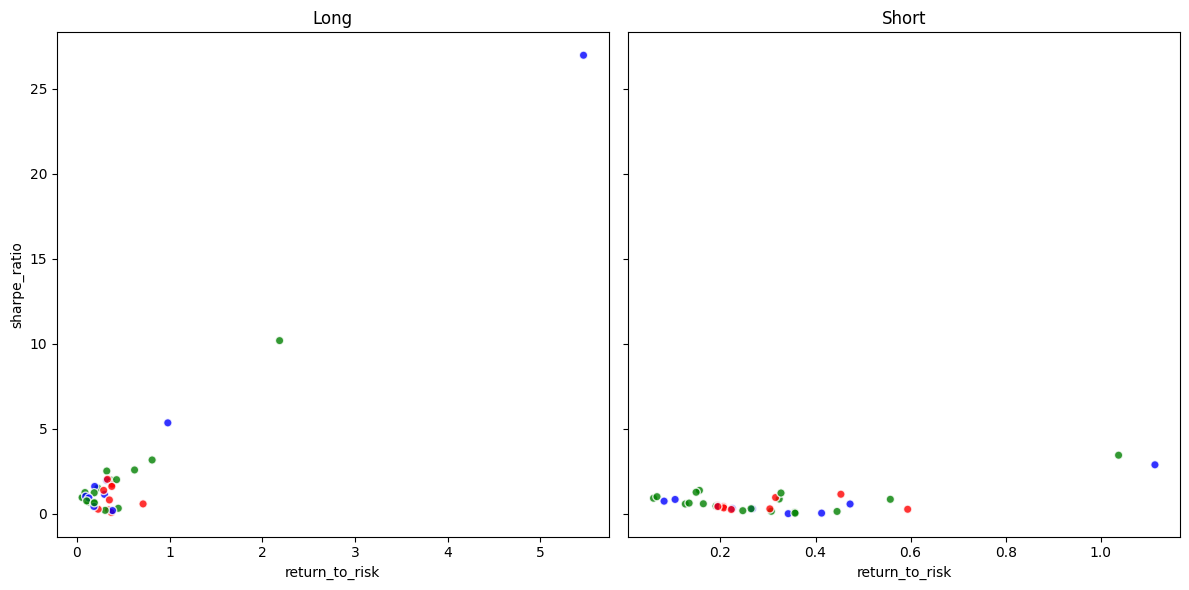

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [13]:
valid = a[(a["position_type"]=="long")].sort_values("pnl",ascending=False).head(20)
valid

,ranking_metric,timeframe,position_type,grouping_type,selection_type,allocation_type,risk_type,selection_percentage,date,pnl,...,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,color,return_to_risk
18,ema_volume_corr,QUARTER,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,26.962874,...,5.465154,1.214734,0.882713,0.675000,1.106827,3.985233,<financial_common.portfolio_management.portfol...,20,blue,4.933598
22,ema_volume_corr,QUARTER,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,10.180354,...,2.187046,1.238871,0.853316,0.562500,1.070191,2.284997,<financial_common.portfolio_management.portfol...,20,green,4.654842
42,ema_volume_corr,MONTH,long,ASSET_CLASS,top,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,5.344162,...,0.981341,1.096319,0.921464,0.566667,1.020549,-0.437892,<financial_common.portfolio_management.portfol...,20,blue,5.445776
6,ema_volume_corr,QUARTER,long,SIC_DESCRIPTION,long_short,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,3.160019,...,0.812071,1.149071,0.847816,0.495203,0.996998,-2.491088,<financial_common.portfolio_management.portfol...,20,green,3.891308
16,ema_volume_corr,QUARTER,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,2.572704,...,0.622575,1.197677,0.794144,0.612500,1.041308,-4.192678,<financial_common.portfolio_management.portfol...,20,green,4.132360
46,ema_volume_corr,MONTH,long,ASSET_CLASS,long_short,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,2.509884,...,0.322932,1.106249,0.903744,0.529167,1.010903,-10.107377,<financial_common.portfolio_management.portfol...,20,green,7.772166
52,ema_volume_corr,WEEK,long,SIC_DESCRIPTION,bottom,equal,coefficient_of_variation,0.5,2024-12-20 00:00:00+00:00,2.020254,...,0.330184,1.034567,0.965658,0.522190,1.001641,-9.765573,<financial_common.portfolio_management.portfol...,20,red,6.118567
40,ema_volume_corr,MONTH,long,ASSET_CLASS,mixed,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,2.002711,...,0.428769,1.104591,0.902584,0.537500,1.011163,-8.795342,<financial_common.portfolio_management.portfol...,20,green,4.670838
8,ema_volume_corr,QUARTER,long,OFFICE,mixed,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,1.973073,...,0.368809,1.163010,0.843242,0.564773,1.023838,-8.703386,<financial_common.portfolio_management.portfol...,20,green,5.349848
10,ema_volume_corr,QUARTER,long,OFFICE,top,equal,coefficient_of_variation,0.5,2024-12-31 00:00:00+00:00,1.967654,...,0.322537,1.152154,0.854405,0.568182,1.023581,-9.968787,<financial_common.portfolio_management.portfol...,20,blue,6.100545


In [14]:
top = valid.head(1).to_dict("records")[0]
top

{'ranking_metric': 'ema_volume_corr',
 'timeframe': 'QUARTER',
 'position_type': 'long',
 'grouping_type': 'ASSET_CLASS',
 'selection_type': 'top',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.5,
 'date': Timestamp('2024-12-31 00:00:00+0000', tz='UTC'),
 'pnl': 26.962874354510454,
 'coefficient_of_variation': 4.933597966092781,
 'portfolio_std': 5.4651543437099335,
 'average_gain': 1.2147343717410852,
 'average_loss': 0.8827127890084738,
 'win_loss_ratio': 0.675,
 'weekly_return': 1.1068273573529865,
 'sharpe_ratio': 3.9852330538957097,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x20751c90e50>,
 'rolling_window': 20,
 'color': 'blue',
 'return_to_risk': 4.933597966092781}

In [15]:
pm = top["portfolio"]
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
        
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            price = Indicator.EMAVolumeCorr.calculate(price,timeframe=top["rolling_window"])
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()
model_end = 2015
backtest_end = 2025
simulation = pd.concat(prices).merge(index[["ticker","name","market_cap","office","sic_description"]],on="ticker",how="left")
simulation["asset_class"] = "common_stock"
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)
trades = pm.trades(simulation.copy()).merge(index[["ticker","name","market_cap"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4006/4006 [02:54<00:00, 22.97it/s]


In [16]:
portfolio

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week
0,2015-03-31 00:00:00+00:00,1.084923,1.084923,46.010834,1.000000,2015,3,1,14
1,2015-06-30 00:00:00+00:00,1.050205,1.139392,51.807462,1.125984,2015,6,2,27
2,2015-09-30 00:00:00+00:00,1.032447,1.176362,46.917335,1.019702,2015,9,3,40
3,2015-12-31 00:00:00+00:00,1.011903,1.190364,51.178733,1.112319,2015,12,4,53
4,2016-03-31 00:00:00+00:00,1.179176,1.403649,46.217867,1.004500,2016,3,1,13
5,2016-06-30 00:00:00+00:00,1.195689,1.678328,48.857211,1.061863,2016,6,2,26
6,2016-09-30 00:00:00+00:00,0.947888,1.590867,52.766231,1.146822,2016,9,3,39
7,2016-12-30 00:00:00+00:00,0.896180,1.425704,68.869408,1.496809,2016,12,4,52
8,2017-03-31 00:00:00+00:00,1.069186,1.524343,70.493683,1.532111,2017,3,1,13
9,2017-06-30 00:00:00+00:00,1.085798,1.655128,73.770726,1.603334,2017,6,2,26


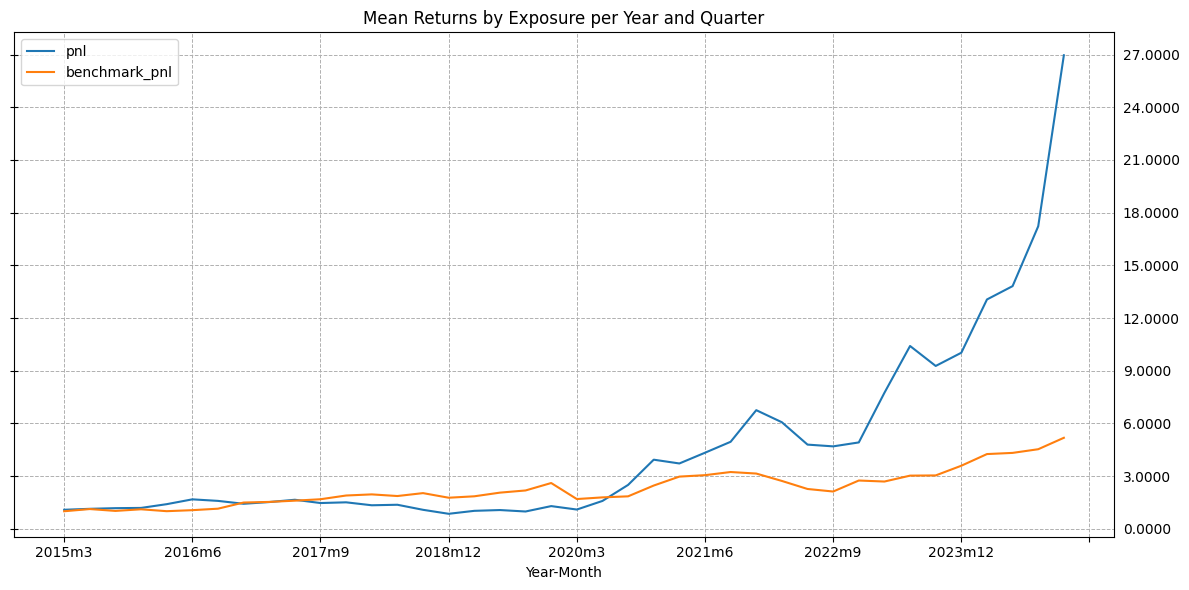

In [17]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
AMD,1.302425
TSLA,1.229068
AVGO,1.196987
KMI,1.179176
META,1.148835
GM,1.084923
PLTR,1.081234
AMZN,1.076300
NVDA,1.069186


In [19]:
trades.sort_values("date",ascending=False).dropna()

,year,quarter,ticker,date,adjclose,sell_price,asset_class,ema_volume_corr,coefficient_of_variation,risk,...,group_percentile,position_type,weight,unweighted_return,winsorized_return,return,name,market_cap,month,week
39,2024,4,TSLA,2024-12-31 00:00:00+00:00,258.020000,403.840000,common_stock,1.506340e+09,0.135722,0.135722,...,0.0,1.0,1,1.565150,1.565150,1.565150,"Tesla, Inc. Common Stock",9.004859e+11,12,1
38,2024,3,TSLA,2024-09-30 00:00:00+00:00,209.860000,261.630000,common_stock,8.850891e+08,0.070793,0.070793,...,0.0,1.0,1,1.246688,1.246688,1.246688,"Tesla, Inc. Common Stock",9.004859e+11,9,40
37,2024,2,MU,2024-06-28 00:00:00+00:00,123.721346,130.917688,common_stock,3.255310e+08,0.125084,0.125084,...,0.0,1.0,1,1.058166,1.058166,1.058166,"Micron Technology, Inc.",8.652239e+10,6,26
36,2024,1,AMD,2024-03-28 00:00:00+00:00,138.580000,180.490000,common_stock,5.028682e+08,0.122294,0.122294,...,0.0,1.0,1,1.302425,1.302425,1.302425,Advanced Micro Devices,1.570127e+11,3,13
35,2023,4,PLTR,2023-12-29 00:00:00+00:00,15.880000,17.170000,common_stock,3.831019e+07,0.133110,0.133110,...,0.0,1.0,1,1.081234,1.081234,1.081234,Palantir Technologies Inc. Class A Common Stock,2.661259e+11,12,52
34,2023,3,AAPL,2023-09-29 00:00:00+00:00,190.808569,169.970042,common_stock,3.086971e+08,0.076749,0.076749,...,0.0,1.0,1,0.890788,0.890788,0.890788,Apple Inc.,3.130149e+12,9,39
33,2023,2,TSLA,2023-06-30 00:00:00+00:00,194.770000,261.770000,common_stock,1.975404e+09,0.172758,0.172758,...,0.0,1.0,1,1.343995,1.343995,1.343995,"Tesla, Inc. Common Stock",9.004859e+11,6,26
32,2023,1,META,2023-03-31 00:00:00+00:00,124.160004,210.954555,common_stock,8.730003e+07,0.177883,0.177883,...,0.0,1.0,1,1.574594,1.574594,1.574594,"Meta Platforms, Inc. Class A Common Stock",1.345910e+12,3,13
31,2022,4,BIIB,2022-12-30 00:00:00+00:00,264.300000,276.920000,common_stock,8.043858e+07,0.070067,0.070067,...,0.0,1.0,1,1.047749,1.047749,1.047749,Biogen Inc. Common Stock,1.741329e+10,12,52
30,2022,3,UNH,2022-09-30 00:00:00+00:00,496.599006,486.261288,common_stock,7.708923e+07,0.043459,0.043459,...,0.0,1.0,1,0.979183,0.979183,0.979183,UNITEDHEALTH GROUP INCORPORATED (Delaware),5.483426e+11,9,39
